In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import __version__ as sklearn_version


In [3]:
# 读取数据
file_path = "datasets/eTraffic_final_lag3_v4.csv"
df = pd.read_csv(file_path)

# 全局变量：需要移除的列
drop_cols = ["local_authority_name", "year", "local_authority_name_encoded",
             "GDP", "pedal_cycles", "two_wheeled_motor_vehicles",
             "cars_and_taxis", "HGVs_3_rigid_axle", "HGVs_5_articulated_axle",
             "all_HGVs", "all_motor_vehicles"]

# 准备特征和目标
features = df.drop(columns=drop_cols)
target = df["GDP"].values  # 目标变量

# 归一化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [4]:
# 模型构建函数
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.3),

        layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.3),

        layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.2),

        layers.Dense(32, activation="relu"),
        layers.Dense(1)  # 输出层
    ])

    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae"])
    return model

# 训练模型（全量训练，不分城市）
final_model = build_model(features_scaled.shape[1])
final_model.fit(features_scaled, target, epochs=150, batch_size=32, verbose=0)


d:\UOB\SEMESTER2\Project\models\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# 通用函数：对每个城市进行预测评估
def evaluate_model_per_city(df, model, features_cols, scaler):
    cities = df["local_authority_name"].unique()
    results = []

    for city in cities:
        df_city = df[df["local_authority_name"] == city].sort_values(by="year")

        X_city = df_city[features_cols]
        X_city_scaled = scaler.transform(X_city)
        y_city_true = df_city["GDP"].values
        y_city_pred = model.predict(X_city_scaled).reshape(-1)

        mae = mean_absolute_error(y_city_true, y_city_pred)
        mse = np.sqrt(mean_squared_error(y_city_true, y_city_pred))
        mape = mean_absolute_percentage_error(y_city_true, y_city_pred)
        r2 = r2_score(y_city_true, y_city_pred)

        results.append({
            "city": city,
            "MAE": mae,
            "MSE": mse,
            "MAPE": mape,
            "R2" : r2
        })

    return pd.DataFrame(results)

# 获取特征列（避免 hardcode）
features_cols = features.columns

# 评估所有城市
results_df = evaluate_model_per_city(df, final_model, features_cols, scaler)

# 显示前几行
print(results_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [26]:
# drop city Darlington in the results_df
results_df = results_df[results_df["city"] != "Darlington"]
results_df

,city,MAE,MSE,MAPE,R2
0,Barnet,6.220985,7.726516,0.077476,0.629508
1,Birmingham,5.382197,7.233635,0.064706,0.670599
2,Blackburn with Darwen,4.413899,5.552203,0.049037,0.686925
3,Blackpool,7.853466,10.628181,0.100030,0.490804
4,Bradford,8.396434,9.809552,0.090466,0.332894
...,...,...,...,...,...
62,Westminster,6.417977,8.689582,0.073325,0.502106
63,Wiltshire,3.700445,4.734987,0.040656,0.835469
64,Wirral,4.778975,6.470690,0.057877,0.763098
65,Wolverhampton,7.370444,8.940654,0.086437,0.518342


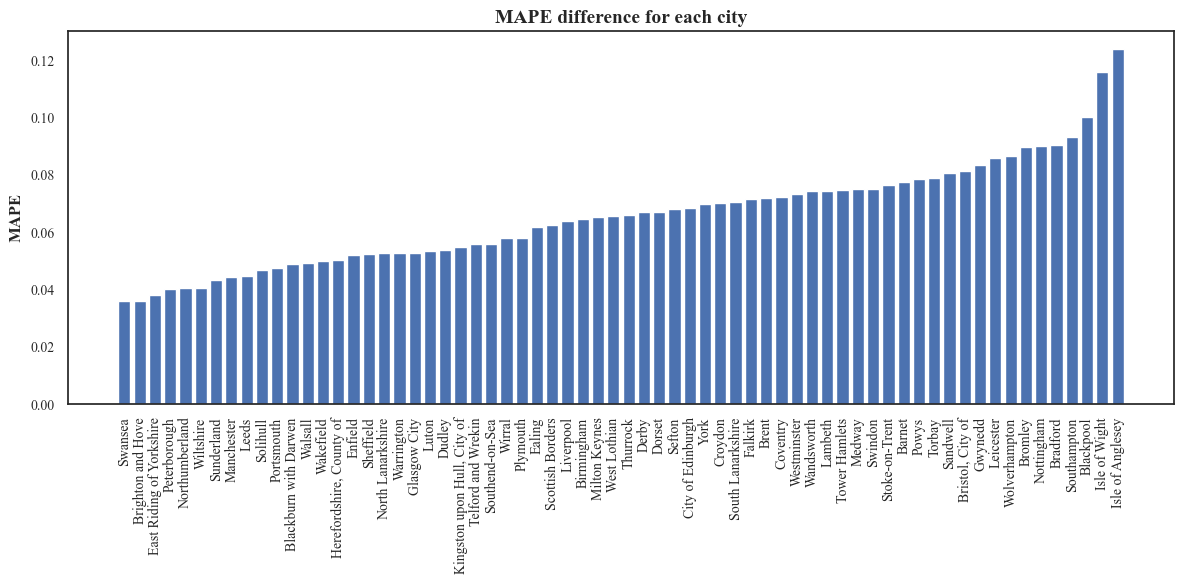

In [27]:
# sorted by MAPE
results_df_s_mape = results_df.sort_values(by="MAPE", ascending=True)

plt.figure(figsize=(12, 6))
plt.bar(results_df_s_mape["city"], results_df_s_mape["MAPE"])
plt.xticks(rotation=90)
plt.ylabel("MAPE")
plt.title("MAPE difference for each city")
plt.tight_layout()
plt.show()

C:\Users\LinG\AppData\Local\Temp\ipykernel_17920\1562128933.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


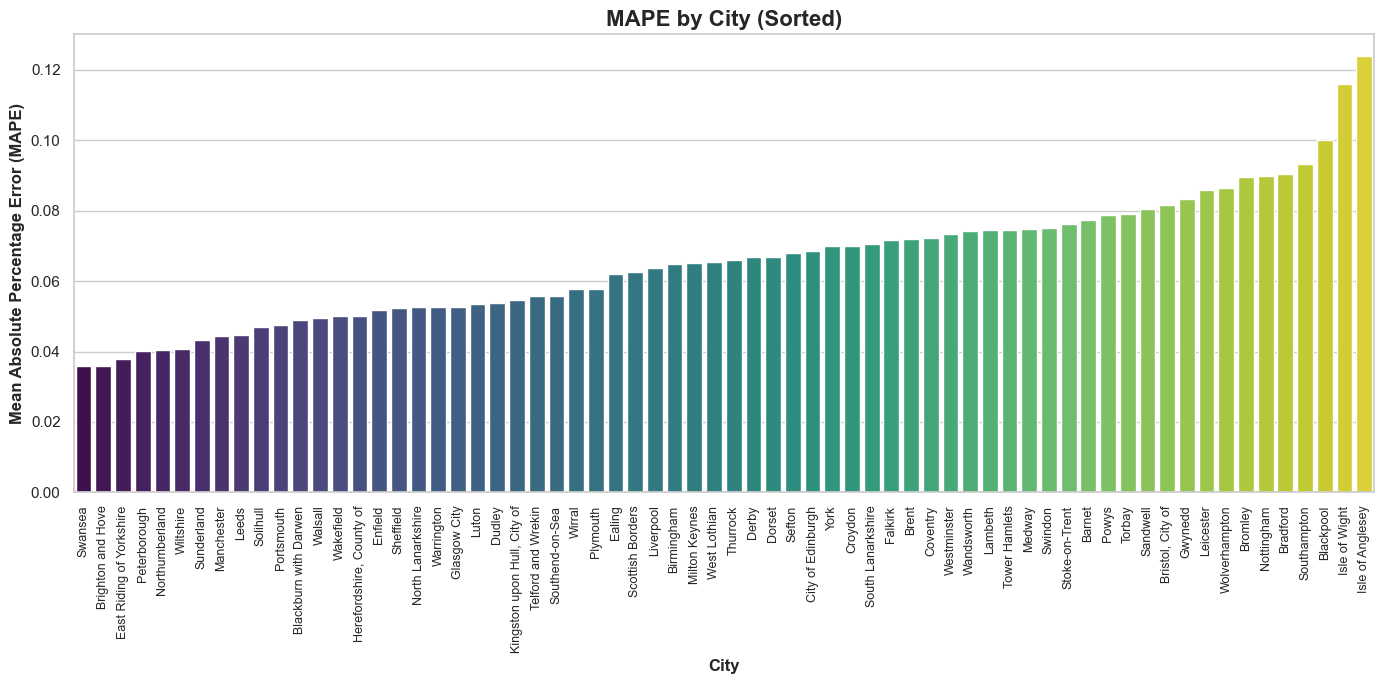

In [28]:
# 排序
results_df_s_mape = results_df.sort_values(by="MAPE", ascending=True)

# 设置 Seaborn 风格
sns.set(style="whitegrid")

# 设置画布大小
plt.figure(figsize=(14, 7))

# 画条形图（颜色自动映射）
barplot = sns.barplot(
    x="city", 
    y="MAPE", 
    data=results_df_s_mape,
    palette="viridis"
)

# 设置标题和标签
plt.title("MAPE by City (Sorted)", fontsize=16)
plt.xlabel("City")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")

# 美化 x 轴标签
plt.xticks(rotation=90, fontsize=9)

# 收紧布局
plt.tight_layout()

# 展示图表
plt.show()


In [29]:
results_df_s_mape = results_df.sort_values(by="MAPE", ascending=True)
results_df_s_mape

,city,MAE,MSE,MAPE,R2
51,Swansea,3.098633,5.021984,0.035873,0.824485
6,Brighton and Hove,2.955462,4.410341,0.035976,0.861762
17,East Riding of Yorkshire,3.369418,4.365117,0.037899,0.881099
37,Peterborough,3.505769,4.490989,0.040097,0.813187
35,Northumberland,3.497765,4.722509,0.040518,0.858316
...,...,...,...,...,...
4,Bradford,8.396434,9.809552,0.090466,0.332894
47,Southampton,7.340794,9.009170,0.093218,0.558293
3,Blackpool,7.853466,10.628181,0.100030,0.490804
24,Isle of Wight,9.012539,10.378173,0.115813,0.437219


C:\Users\LinG\AppData\Local\Temp\ipykernel_17920\3509098478.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


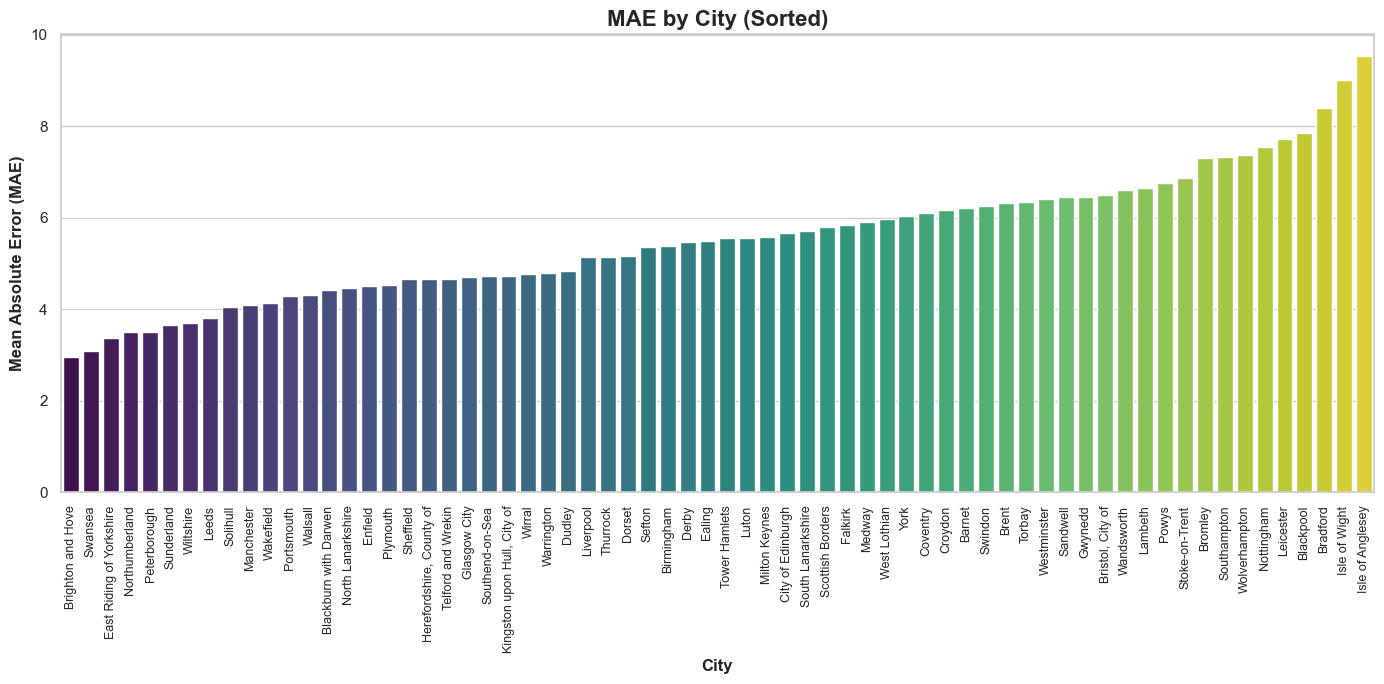

In [30]:
# 排序
results_df_s_mae = results_df.sort_values(by="MAE", ascending=True)

# 设置 Seaborn 风格
sns.set(style="whitegrid")

# 设置画布大小
plt.figure(figsize=(14, 7))

# 画条形图（颜色自动映射）
barplot = sns.barplot(
    x="city", 
    y="MAE", 
    data=results_df_s_mae,
    palette="viridis"
)

# 设置标题和标签
plt.title("MAE by City (Sorted)", fontsize=16)
plt.xlabel("City")
plt.ylabel("Mean Absolute Error (MAE)")

# 美化 x 轴标签
plt.xticks(rotation=90, fontsize=9)

# 收紧布局
plt.tight_layout()

# 展示图表
plt.show()


In [31]:
results_df_s_mae = results_df.sort_values(by="MAE", ascending=True)
results_df_s_mae

,city,MAE,MSE,MAPE,R2
6,Brighton and Hove,2.955462,4.410341,0.035976,0.861762
51,Swansea,3.098633,5.021984,0.035873,0.824485
17,East Riding of Yorkshire,3.369418,4.365117,0.037899,0.881099
35,Northumberland,3.497765,4.722509,0.040518,0.858316
37,Peterborough,3.505769,4.490989,0.040097,0.813187
...,...,...,...,...,...
28,Leicester,7.715360,9.030366,0.085762,0.426154
3,Blackpool,7.853466,10.628181,0.100030,0.490804
4,Bradford,8.396434,9.809552,0.090466,0.332894
24,Isle of Wight,9.012539,10.378173,0.115813,0.437219


In [40]:
# 设置学术风格参数
sns.set(style="whitegrid", 
        font="Times New Roman",
        rc={
            'font.size': 12,
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'grid.linewidth': 0.5,
            'axes.linewidth': 1.2
        })

# 创建横向条形图
plt.figure(figsize=(10, 12 if len(results_df_s_mape)>15 else 8))
ax = plt.gca()

# 生成颜色编码：突出显示最优值
palette = ["#2C5F8A" if x == results_df_s_mape["MAPE"].min() 
          else "#B3C3D6" for x in results_df_s_mape["MAPE"]]

# 绘制条形图
bar = sns.barplot(
    x="MAPE", 
    y="city", 
    data=results_df_s_mape,
    palette=palette,
    linewidth=0.5,
    edgecolor="black"
)

# 添加数据标签
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005,  # 右侧偏移
            p.get_y() + p.get_height()/2,
            f'{width:.4f}%',  # 格式化为百分比
            ha='left', 
            va='center',
            fontsize=9)

# 标题与轴标签
plt.title("Regional GDP(CVM index) Forecast Accuracy Distribution", 
         weight='bold', pad=20)
plt.xlabel("Mean Absolute Percentage Error (MAPE, %)")
plt.ylabel(None)

# 网格线设置
ax.xaxis.grid(True, linestyle='--', alpha=0.6)
ax.yaxis.grid(False)

# 刻度优化
max_mape = results_df_s_mape["MAPE"].max()
ax.set_xlim(0, 0.15)  # 强制限定显示范围
plt.xticks(np.arange(0, 0.15 + 0.03, 0.03),  # 生成0, 0.03, 0.06,...0.15刻度
         labels=[f'{x:.2f}%' for x in np.arange(0, 0.15 + 0.03, 0.03)])  # 带百分号

ax.tick_params(axis='y', length=0)  # 隐藏y轴刻度线

# 添加分析注释
analysis_text = f"Best performance: {results_df_s_mape['city'].iloc[0]} ({results_df_s_mape['MAPE'].iloc[0]:.4f}%)\nWorst performance: {results_df_s_mape['city'].iloc[-1]} ({results_df_s_mape['MAPE'].iloc[-1]:.4f}%)"
plt.text(0.95, 0.95, analysis_text,
        transform=ax.transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
        fontsize=10)

# 边框控制
sns.despine(left=True)

# 紧凑布局
plt.tight_layout(pad=3)

# save as pdf
plt.savefig("gdp_forecast/MAPE_distribution.pdf")
plt.close()

C:\Users\LinG\AppData\Local\Temp\ipykernel_17920\1292352261.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


In [ ]:
# 设置学术风格参数
sns.set(style="whitegrid", 
        font="Times New Roman",
        rc={
            'font.size': 12,
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'grid.linewidth': 0.5,
            'axes.linewidth': 1.2
        })

# 创建横向条形图
plt.figure(figsize=(10, 12 if len(results_df_s_mape)>15 else 8))
ax = plt.gca()

# 生成颜色编码：突出显示最优值
palette = ["#2C5F8A" if x == results_df_s_mape["MAE"].min() 
          else "#B3C3D6" for x in results_df_s_mape["MAE"]]

# 绘制条形图
bar = sns.barplot(
    x="MAE", 
    y="city", 
    data=results_df_s_mape,
    palette=palette,
    linewidth=0.5,
    edgecolor="black"
)

# 添加数据标签（转换为百分比显示）
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.2,  # 右侧偏移量根据新范围调整
            p.get_y() + p.get_height()/2,
            f'{width:.1f}%',  # 保留1位小数
            ha='left', 
            va='center',
            fontsize=9,
            color='#2C5F8A')  # 统一标签颜色

# 标题与轴标签
plt.title("Regional GDP (CVM Index) Forecast Accuracy Distribution", 
         weight='bold', pad=20)
plt.xlabel("Mean Absolute Error (MAE, %)")
plt.ylabel(None)

# 网格线设置
ax.xaxis.grid(True, linestyle='--', alpha=0.6)
ax.yaxis.grid(False)

# 动态设置坐标轴范围
max_mae = results_df_s_mape["MAE"].max()
ax.set_xlim(0, max(12, max_mae * 1.15))  # 保证至少显示到12%，上浮15%空间
plt.xticks(np.arange(0, max(12, max_mae * 1.15) + 2, 2),  # 2%间隔
         labels=[f'{int(x)}%' for x in np.arange(0, max(12, max_mae * 1.15) + 2, 2)])

ax.tick_params(axis='y', length=0)

# 添加分析注释（调整位置至左下角）
analysis_text = (f"Best: {results_df_s_mape['city'].iloc[0]} ({results_df_s_mape['MAE'].iloc[0]:.1f}%)\n"
                f"Worst: {results_df_s_mape['city'].iloc[-1]} ({results_df_s_mape['MAE'].iloc[-1]:.1f}%)")
plt.text(0.05, 0.15, analysis_text,
        transform=ax.transAxes, ha='left',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='#2C5F8A', boxstyle='round'),
        fontsize=10,
        color='#2C5F8A')

# 添加基准线（行业平均假设为5%）
ax.axvline(x=5, color='#B34045', linestyle=':', linewidth=1.5, alpha=0.8)
ax.text(5, 0.95, 'Industry Average (5.0%)',
       transform=ax.transAxes, color='#B34045',
       ha='right', va='top')

# 边框控制
sns.despine(left=True)

# 紧凑布局
plt.tight_layout(pad=3)

# 保存矢量图
plt.savefig("gdp_forecast/MAE_distribution.pdf", bbox_inches='tight')
plt.close()

C:\Users\LinG\AppData\Local\Temp\ipykernel_17920\3534462018.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
C:\Users\LinG\AppData\Local\Temp\ipykernel_17920\3534462018.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=3)


In [32]:
# 选定城市
SelectedRegion = "Darlington"
df_selected = df[df["local_authority_name"] == SelectedRegion].sort_values(by="year")

# 特征处理
X_selected = df_selected[features.columns]
X_selected_scaled = scaler.transform(X_selected)
y_actual = df_selected["GDP"].values
years = df_selected["year"].values

# 预测
y_pred = final_model.predict(X_selected_scaled).reshape(-1)

# 创建绘图数据框
plot_df = pd.DataFrame({
    "Year": years,
    "Actual GDP": y_actual,
    "Predicted GDP": y_pred
})

# 设置 Seaborn 风格
sns.set(style="white", 
        font="Times New Roman",
        rc={
            'font.size': 12,
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 10,
            'axes.titleweight': 'bold',
            'axes.labelweight': 'bold'
        })

# 初始化画布
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
fig.patch.set_facecolor('white')

# 绘制实际和预测曲线
sns.lineplot(data=plot_df, x="Year", y="Actual GDP", 
             marker='o', markersize=8, markeredgecolor='none',
             linewidth=2, color='#2C5F8A', label='Actual GDP', ax=ax)

sns.lineplot(data=plot_df, x="Year", y="Predicted GDP", 
             marker='s', markersize=8, markeredgecolor='none',
             linewidth=2, linestyle='--', color='#B34045', label='Predicted GDP', ax=ax)

# 图形标题
plt.title(f"Actual vs Predicted GDP for {SelectedRegion}")

# 坐标轴设置
ax.set(xlabel=None, ylabel="GDP (CVM index)", 
       xlim=(plot_df["Year"].min()-0.5, plot_df["Year"].max()+0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 添加2019年标线
ax.axvline(x=2019, color='#4A4A4A', linewidth=1.5, linestyle=':', alpha=0.8)

# 添加文字注释
ax.text(2019, ax.get_ylim()[1]*0.95, '', 
        color='#4A4A4A', fontsize=10, ha='center', va='top',
        backgroundcolor=(1,1,1,0.7))

# 网格线
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.xaxis.grid(False)

# 边框控制
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.2)

# 图例设置
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles, labels, frameon=True, 
               loc='upper left', bbox_to_anchor=(0.02, 0.98),
               handlelength=2, handletextpad=0.5)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_facecolor('white')

# 刻度标签
plt.xticks(plot_df["Year"], rotation=45, ha='right', rotation_mode='anchor')

# 数据来源注释（你可以加网址或说明）
plt.text(0.99, 0.01, '',
         transform=ax.transAxes, ha='right', va='bottom',
         fontsize=8, color='#666666', wrap=True)

# 布局 & 保存
plt.tight_layout(pad=2)
plt.savefig(f'gdp_forecast/{SelectedRegion}.pdf', bbox_inches='tight')
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
